In [1]:
# Importing libraries

%matplotlib inline

import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
import math
from scipy.stats import norm
import statsmodels.api as sm
import requests
from io import BytesIO
import datetime as dt
plt.style.use('fivethirtyeight')
import seaborn as sns
#from hmmlearn.hmm import GaussianHMM
#from matplotlib.dates import YearLocator, MonthLocator
from matplotlib import cm, pyplot as plt
#import alpaca_trade_api as tradeapi


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#!pip install hmmlearn

In [3]:
# Set Data Date
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2020, 1, 1)

In [4]:
# Download Data
spy_df = pdr.get_data_yahoo(symbols='SPY', start = start, end = end)
vix_df = pdr.get_data_yahoo(symbols='^VIX', start = start, end = end)

In [5]:
spy_df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-24,321.519989,320.899994,321.470001,321.230011,20270000.0,316.685272
2019-12-26,322.950012,321.640015,321.649994,322.940002,30911200.0,318.371063
2019-12-27,323.799988,322.279999,323.739990,322.859985,42528800.0,318.292175
2019-12-30,323.100006,320.549988,322.950012,321.079987,49729100.0,316.537384
2019-12-31,322.130005,320.149994,320.529999,321.859985,57077300.0,317.306335


In [6]:
#spy_df = spy_df.resample('D').asfreq()
#vix_df = vix_df.resample('D').asfreq()

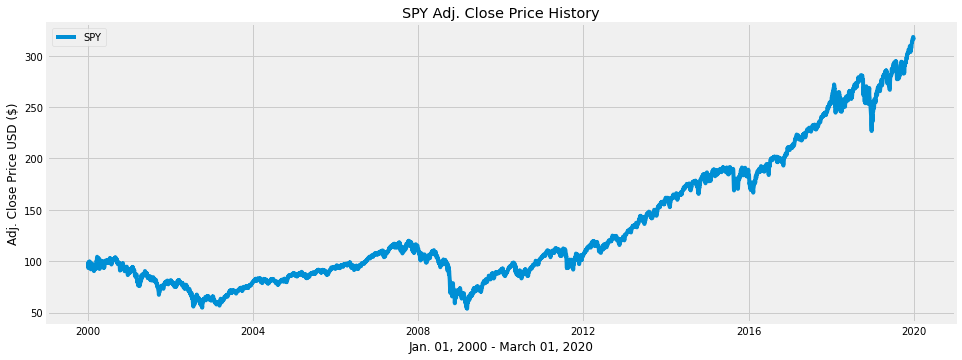

In [7]:
plt.figure(figsize=(14.5,5.5))
plt.plot(spy_df['Adj Close'], label = 'SPY')
plt.title('SPY Adj. Close Price History')
plt.xlabel('Jan. 01, 2000 - March 01, 2020')
plt.ylabel('Adj. Close Price USD ($)')
plt.legend(loc='upper left')
plt.show()

In [8]:
df = pd.DataFrame(index=spy_df.index)
df['spy_df'] = spy_df['Adj Close']
df['vix_df'] = vix_df['Adj Close']

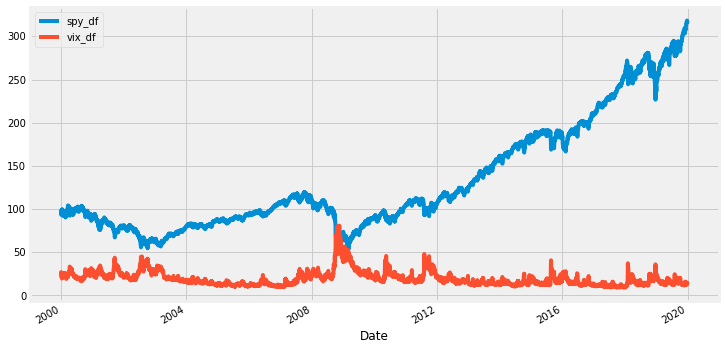

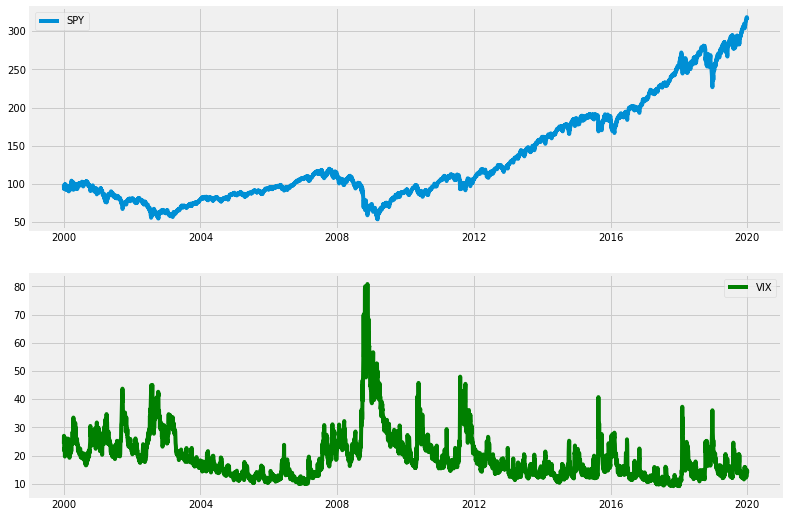

In [9]:
#df[['spy_df', 'vix_df']].plot(subplots=True)
df[['spy_df', 'vix_df']].plot(figsize=(11,6))
fig, ax = plt.subplots(figsize=(12,9))
ax = plt.subplot(211)
plt.plot(df['spy_df'],label='SPY')
plt.legend(loc=0)
ax = plt.subplot(212)
plt.plot(df['vix_df'],label='VIX',color='g') # Indicator that follows the Put Option of S&P 500
plt.legend(loc=0)

Plot Correlation between SPY and VIX. This is inverse correlation to each other.

In [10]:
np.corrcoef(spy_df['Adj Close'], vix_df['Adj Close'])

array([[ 1.        , -0.43591278],
       [-0.43591278,  1.        ]])

In [11]:
# Calculate Daily returns

spy_df['Daily Return'] = (spy_df['Adj Close'] / spy_df['Adj Close'].shift(1)) -1
spy_df.dropna(inplace = True)

In [12]:
# Fit the markov model
mod_spy_df = sm.tsa.MarkovAutoregression(spy_df['Daily Return'], k_regimes = 2, order = 1, switching_ar = True)
res_spy_df = mod_spy_df.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [13]:
# Get the results
res_spy_df.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:             Daily Return   No. Observations:                 5029
Model:             MarkovAutoregression   Log Likelihood               15305.323
Date:                  Sat, 24 Oct 2020   AIC                         -30596.646
Time:                          19:32:00   BIC                         -30550.986
Sample:                               0   HQIC                        -30580.648
                                 - 5029                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.001     -3.080      0.002      -0.005      -0.001
ar.L1          1.0000      0.078     12.874      0.000       0.848       1.152
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      5.079      0.000       0.001       0.001
ar.L1         -0.1966      0.018    -10.928      0.000      -0.232      -0.161
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0001   2.67e-06     44.791      0.000       0.000       0.000
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.0748      0.033      2.254      0.024       0.010       0.140
p[1->0]        0.1257      0.025      5.019      0.000       0.077       0.175
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

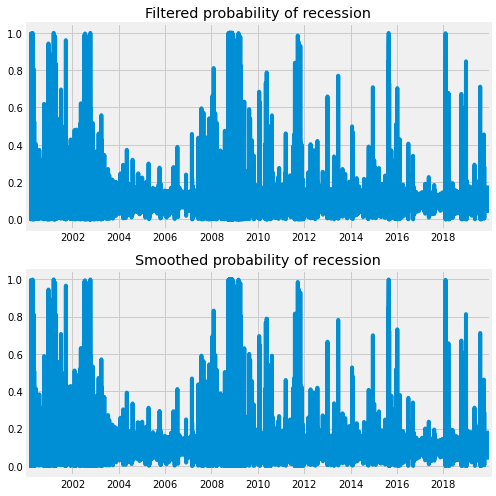

In [14]:
# Plot the probabilties

fig, axes = plt.subplots(2, figsize=(7,7))

ax = axes[0]
ax.plot(res_spy_df.filtered_marginal_probabilities[0])
ax.set_xlim(spy_df.index[4], spy_df.index[-1])
ax.set(title = 'Filtered probability of recession')

ax = axes[1]
ax.plot(res_spy_df.smoothed_marginal_probabilities[0])
ax.set_xlim(spy_df.index[4], spy_df.index[-1])
ax.set(title = 'Smoothed probability of recession')

fig.tight_layout()

In [15]:
# Get the expected duration
print(res_spy_df.expected_durations)

[1.08085332 7.953931  ]


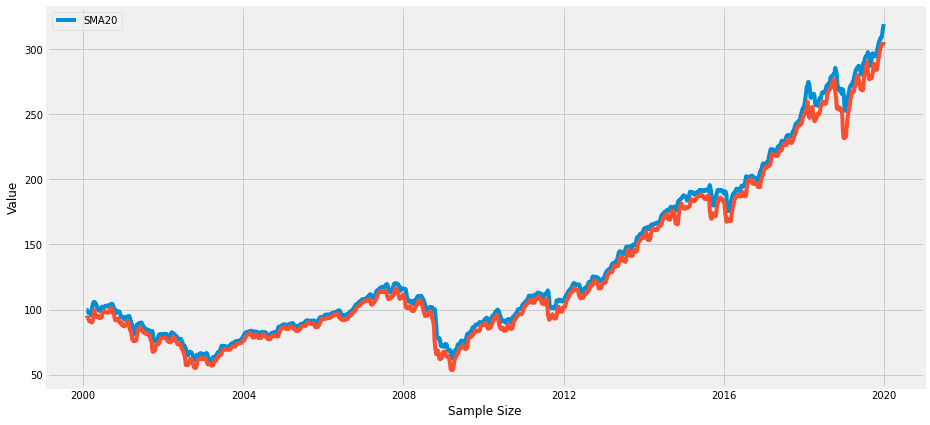

In [16]:
# Adding Bollinger Bands as technical indicator for portfolio rebalancing

spy_df['20 day moving average'] = spy_df['Adj Close'].rolling(window=20).mean()

spy_df['20 day std'] = spy_df['Adj Close'].rolling(window=20).std()

spy_df['Upper Band'] = spy_df['20 day moving average'] + (spy_df['20 day std'] * 1.5)
spy_df['Lower Band'] = spy_df['20 day moving average'] - (spy_df['20 day std'] * 1.5)
# Plot of SMA20
fig, ax = plt.subplots(figsize =(14,7))
plt.plot (spy_df['Upper Band'], label='SMA20')
plt.plot (spy_df['Lower Band'])
plt.xlabel('Sample Size')
plt.ylabel('Value')
plt.legend(loc='upper left')
plt.show()

Setup Call & Put Option

In [17]:
# Setup Call & Put functions
def d_1(sigma, T, S, K, r):
    return 1/(sigma*np.sqrt(T))*(np.log(S/K)+(r+(sigma**2)/2)*T)

def d_2(d_1, sigma, T):
    return d_1 - sigma*np.sqrt(T)

def Call(sigma, T, S, K, r):
    d1 = d_1(sigma, T, S, K, r)
    d2 = d_2(d1, sigma, T)
    return norm.cdf(d1)*S-norm.cdf(d2)*K*np.exp(-r*T)

def Put(sigma, T, S, K, r):
    d1 = d_1(sigma, T, S, K, r)
    d2 = d_2(d1, sigma, T)
    return norm.cdf(-d2)*K*np.exp(-r*T)-norm.cdf(-d1)*S


Object-Oriented Solution

In [18]:
class option:
    """
    Option class to keep track of invested options, their type (Call/Put), direction (long/short),
    Strike, expiry and volatility regime it has been created in.
    """
    def __init__(self, opt_type, opt_dir, opt_strike, opt_exp, opt_reg):
        self.opt_type = opt_type
        self.opt_dir = opt_dir
        self.opt_strike = opt_strike
        self.opt_exp = opt_exp
        self.opt_reg = opt_reg
        self.state = 'invested'
    
    def option_payout(self, S):
        """
        Calculates an option pay-out depending on direction (long/short),
        option type (call/put), current underlying level (S) and the option's strike (K)
        """
        setattr(self, 'state', 'expired')        
        if self.opt_dir == "s":
            if self.opt_type == "p":
                return -max(0, self.opt_strike-S)
            else:
                return -max(0, S-self.opt_strike)
        else:
            if self.opt_type == "p":
                return max(0, self.opt_strike-S)
            else:
                return max(0, S-self.opt_strike)

    def option_premium(self, vola, cur_date, cur_close):
        """
        Calculates the option's value vor provided volatility, date and current underlying price.
        """
        if self.opt_type == "p":
            prem = Put(vola, timediff(self.opt_exp, cur_date), cur_close, self.opt_strike, 0.005)
        else:
            prem = Call(vola, timediff(self.opt_exp, cur_date), cur_close, self.opt_strike, 0.005)
        if self.opt_dir == "l":
            return -prem
        else:
            return prem
    
    pass

Function for Date 1 and 2

In [19]:
def timediff(date1, date2):
    """
    Helper function to calculate 30/360 yearfrac for calculating
    """
    return (date1.day + date1.month * 30 + date1.year * 360 - (date2.day + date2.month * 30 + date2.year * 360))/360

Portfolio rebalancing
The following code presents the portfolio rebalancing according to the ruleset. We first initialize a few variables which help us to keep track of the current investment state, portfolio value, and cash-flows.

While we loop through each day of the underlying's data frame (spy_df), we check if the portfolio is currently invested, if an open position expires or if a position has to be rolled to a different position in adherence with our rules.

In [20]:
# Initial investment state = 0 (not invested)
inv_state = 0

# Setting initial portfolio value
pf_value = 0

# Creating list to keep track of portfolio values and cash-flows
pf_value_list = []
pf_cf_list = []

# Create portfolio dataframe with underlyings date index
pf_df = pd.DataFrame(index=spy_df.index)

# Looping through the data and rebalance portfolio

for day in range(len(spy_df)):

    cur_close = spy_df["Adj Close"].iloc[day]
    opt_return = 0
    opt_prem = 0
    current_val = 0
    
    # Set regime state according to smoothed marginal probabilities
    # (0 = low vol | 1 = high vol)
    if spy_df.index[day] >= res_spy_df.smoothed_marginal_probabilities.index[0]:
        reg_state = round(res_spy_df.smoothed_marginal_probabilities.loc[spy_df.index[day]][0])

    # Expiry of options
    if inv_state == 1 and spy_df.index[day] > new_option.opt_exp:
        # Calculating option premium at expiry
        opt_return = new_option.option_payout(spy_df["Adj Close"].iloc[day])
        print("Option expires", spy_df.index[day], "return:", opt_return)

        # Setting investment state to "not invested" = 0
        inv_state = 0

    # High vol and above upper band -> short call
    if cur_close > spy_df["Upper Band"].iloc[day] and reg_state == 1:
        print("State:", reg_state)
        
        if inv_state == 1 and new_option.opt_reg != reg_state:
            #Book out existing option
            opt_prem -= new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)
            print("option booked out on", spy_df.index[day], "close-out premium:", -opt_prem, "option type:", new_option.opt_type, "direction:", new_option.opt_dir)
            
            # Create new option
            new_option = option("c", "s", cur_close, spy_df.index[day] + dt.timedelta(days=30), reg_state)
            opt_prem += new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)
        elif inv_state == 0:
            # Create new option
            new_option = option("c", "s", cur_close, spy_df.index[day] + dt.timedelta(days=30), reg_state)
            opt_prem += new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)

            # Set invested state to 1 = invested
            inv_state = 1

        print("option invested on", spy_df.index[day], "premium:", opt_prem, "option type:", new_option.opt_type, "direction:", new_option.opt_dir)

    # High vol and below lower band -> short put      
    if cur_close > spy_df["Upper Band"].iloc[day] and inv_state == 0 and reg_state == 1:
        print("State:", reg_state)
        
        if inv_state == 1 and new_option.opt_reg != reg_state:
            #Book out existing option
            opt_prem -= new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)
            print("option booked out on", spy_df.index[day], "close-out premium:", -opt_prem, "option type:", new_option.opt_type, "direction:", new_option.opt_dir)
            
            # Create new option
            new_option = option("p", "s", cur_close, spy_df.index[day] + dt.timedelta(days=30), reg_state)
            opt_prem += new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)

        elif inv_state == 0:
            # Create new option
            new_option = option("p", "s", cur_close, spy_df.index[day] + dt.timedelta(days=30), reg_state)
            opt_prem += new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)

            # Set invested state to 1 = invested
            inv_state = 1

        print("option invested on", spy_df.index[day], "premium:", opt_prem, "option type:", new_option.opt_type, "direction:", new_option.opt_dir)

    # Low vol and below lower band -> long call      
    if cur_close < spy_df["Lower Band"].iloc[day] and inv_state == 0 and reg_state == 0:
        print("State:", reg_state)
        
        if inv_state == 1 and new_option.opt_reg != reg_state:
            #Book out existing option
            opt_prem -= new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)
            print("option booked out on", spy_df.index[day], "close-out premium:", -opt_prem, "option type:", new_option.opt_type, "direction:", new_option.opt_dir)
            
            # Create new option
            new_option = option("c", "l", cur_close, spy_df.index[day] + dt.timedelta(days=30), reg_state)
            opt_prem += new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)

        elif inv_state == 0:
            # Create new option
            new_option = option("c", "l", cur_close, spy_df.index[day] + dt.timedelta(days=30), reg_state)
            opt_prem += new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)

            # Set invested state to 1 = invested
            inv_state = 1

        print("option invested on", spy_df.index[day], "premium:", opt_prem, "option type:", new_option.opt_type, "direction:", new_option.opt_dir)

    # Low vol and above upper band -> long put      
    if cur_close > spy_df["Upper Band"].iloc[day] and inv_state == 0 and reg_state == 0:
        print("State:", reg_state)
        
        if inv_state == 1 and new_option.opt_reg != reg_state:
            #Book out existing option
            opt_prem -= new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)
            print("option booked out on", spy_df.index[day], "close-out premium:", -opt_prem, "option type:", new_option.opt_type, "direction:", new_option.opt_dir)
            
            # Create new option
            new_option = option("p", "l", cur_close, spy_df.index[day] + dt.timedelta(days=30), reg_state)
            opt_prem += new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)

        elif inv_state == 0:
            # Create new option
            new_option = option("p", "l", cur_close, spy_df.index[day] + dt.timedelta(days=30), reg_state)
            opt_prem += new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)

            # Set invested state to 1 = invested
            inv_state = 1


        print("option invested on", spy_df.index[day], "premium:", opt_prem, "option type:", new_option.opt_type, "direction:", new_option.opt_dir)        

    if inv_state == 1:
        current_val = -new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)        
        
    # Keeping track of every day's portfolio value and cash-flows
    pf_cf = opt_prem + opt_return 
    pf_value = current_val+ pf_cf + np.sum(pf_cf_list[:-1])
    print("pf value:", pf_value, "on day", spy_df.index[day], "CF:", pf_cf)
    pf_value_list.append(pf_value)
    pf_cf_list.append(pf_cf)
        
print("pf end value:", pf_value)

# Adding each day's portfolio value to the portfolio dataframe
pf_df["Value"] = pf_value_list
pf_df["Daily CF"] = pf_cf_list

pf value: 0.0 on day 2000-01-04 00:00:00 CF: 0
pf value: 0.0 on day 2000-01-05 00:00:00 CF: 0
pf value: 0 on day 2000-01-06 00:00:00 CF: 0
pf value: 0 on day 2000-01-07 00:00:00 CF: 0
pf value: 0 on day 2000-01-10 00:00:00 CF: 0
pf value: 0 on day 2000-01-11 00:00:00 CF: 0
pf value: 0 on day 2000-01-12 00:00:00 CF: 0
pf value: 0 on day 2000-01-13 00:00:00 CF: 0
pf value: 0 on day 2000-01-14 00:00:00 CF: 0
pf value: 0 on day 2000-01-18 00:00:00 CF: 0
pf value: 0 on day 2000-01-19 00:00:00 CF: 0
pf value: 0 on day 2000-01-20 00:00:00 CF: 0
pf value: 0 on day 2000-01-21 00:00:00 CF: 0
pf value: 0 on day 2000-01-24 00:00:00 CF: 0
pf value: 0 on day 2000-01-25 00:00:00 CF: 0
pf value: 0 on day 2000-01-26 00:00:00 CF: 0
pf value: 0 on day 2000-01-27 00:00:00 CF: 0
pf value: 0 on day 2000-01-28 00:00:00 CF: 0
pf value: 0 on day 2000-01-31 00:00:00 CF: 0
pf value: 0 on day 2000-02-01 00:00:00 CF: 0
pf value: 0 on day 2000-02-02 00:00:00 CF: 0
pf value: 0 on day 2000-02-03 00:00:00 CF: 0
pf val

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


Streaming output truncated to the last 5000 lines.
pf value: 2.6633668417862886 on day 2002-04-12 00:00:00 CF: 0
pf value: 2.3830255010909838 on day 2002-04-15 00:00:00 CF: 0
pf value: 2.980774174816599 on day 2002-04-16 00:00:00 CF: 0
pf value: 2.880290208637984 on day 2002-04-17 00:00:00 CF: 0
pf value: 2.735290459318822 on day 2002-04-18 00:00:00 CF: 0
pf value: 2.7654244261797807 on day 2002-04-19 00:00:00 CF: 0
pf value: 2.2085425063287083 on day 2002-04-22 00:00:00 CF: 0
pf value: 2.0972891905163067 on day 2002-04-23 00:00:00 CF: 0
pf value: 1.9196652731073822 on day 2002-04-24 00:00:00 CF: 0
pf value: 1.8968303144930427 on day 2002-04-25 00:00:00 CF: 0
pf value: 1.7594595260749002 on day 2002-04-26 00:00:00 CF: 0
pf value: 1.722913401067668 on day 2002-04-29 00:00:00 CF: 0
pf value: 1.7190569305086751 on day 2002-04-30 00:00:00 CF: 0
pf value: 1.7180433109322424 on day 2002-05-01 00:00:00 CF: 0
pf value: 1.7147328585213844 on day 2002-05-02 00:00:00 CF: 0
pf value: 1.71471428549

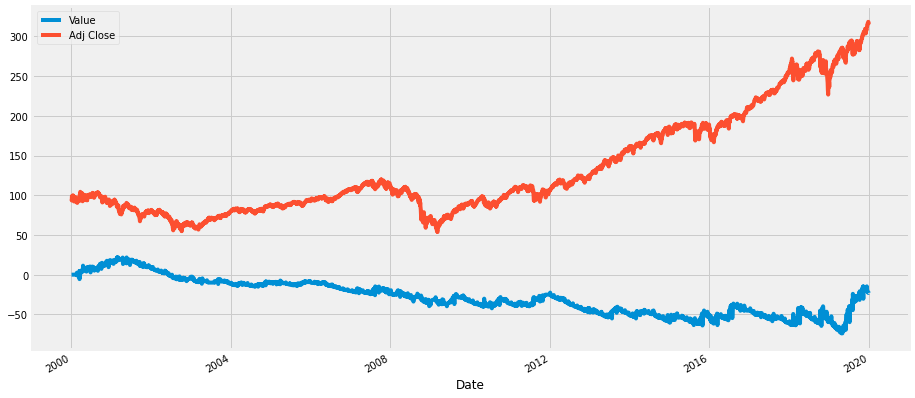

In [21]:
fig, ax = plt.subplots(figsize =(14,7))
pf_df['Value'].plot()
spy_df['Adj Close'].plot()
plt.legend()